# Задание 3

In [6]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [7]:
from sklearn import datasets

boston = datasets.load_boston()

df = pd.DataFrame(data=boston.data, columns=boston.feature_names)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [8]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target, 
    test_size=0.25, random_state=777)

In [9]:
import sys

class DecisionTreeRegressor:
    class Node:
        NUM_THRESHOLDS_PER_FEATURE = 15
        
        def __init__(self):
            self.left = None
            self.right = None
            self.split_feature_index = 0
            self.split_threshold = 0.0

        def _split(self, X, y, feature_index, threshold):
            y_left = [t for obj, t in zip(X, y) if obj[feature_index] < threshold]
            y_right = [t for obj, t in zip(X, y) if obj[feature_index] >= threshold]
            return y_left, y_right

        def _find_best_split(self, X, y):
            best_quality = sys.maxsize

            for i in range(X.shape[1]):
                for t in np.linspace(min(x[i] for x in X), max(x[i] for x in X), 
                                     num=DecisionTreeRegressor.Node.NUM_THRESHOLDS_PER_FEATURE):
                    y_left, y_right = self._split(X, y, i, t)
                    curr_quality = len(y_left) / len(y) * np.std(y_left) + len(y_right) / len(y) * np.std(y_right)

                    if curr_quality < best_quality:
                        best_quality = curr_quality
                        self.split_feature_index = i
                        self.split_threshold = t

        def split(self, X, y):
            self._find_best_split(X, y)

            X_left, y_left, X_right, y_right = [], [], [], []

            for obj, f in zip(X, y):
                if obj[self.split_feature_index] < self.split_threshold:
                    X_left.append(obj)
                    y_left.append(f)
                else:
                    X_right.append(obj)
                    y_right.append(f)

            return map(np.asarray, [X_left, y_left, X_right, y_right])

    class Leaf:
        def __init__(self, prediction):
            self.prediction = prediction

    def __init__(self, max_depth=sys.maxsize, min_samples_leaf=1):  
        self.root = None
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf

    def _build(self, X, y, depth):
        if depth >= self.max_depth or len(X) <= self.min_samples_leaf:
            node = DecisionTreeRegressor.Leaf(np.mean(y))
        else:
            node = DecisionTreeRegressor.Node()
            X_left, y_left, X_right, y_right = node.split(X, y)
            node.left = self._build(X_left, y_left, depth + 1)
            node.right = self._build(X_right, y_right, depth + 1)

        return node

    def _predict(self, x, node):
        if isinstance(node, DecisionTreeRegressor.Leaf):
            return node.prediction
        elif x[node.split_feature_index] < node.split_threshold:
            return self._predict(x, node.left)
        else:
            return self._predict(x, node.right)

    def fit(self, X, y):
        self.root = self._build(X, y, 0)

    def predict(self, X):
        return np.asarray([self._predict(x, self.root) for x in X])

In [10]:
import warnings
warnings.filterwarnings('ignore')  # Nope
from sklearn.metrics import mean_squared_error

dtr = DecisionTreeRegressor(max_depth=5)
%time dtr.fit(X_train, y_train)
print(mean_squared_error(dtr.predict(X_test), y_test))

CPU times: user 751 ms, sys: 83 µs, total: 751 ms
Wall time: 751 ms
15.2228660782


Сравним с классом из sklearn:

In [11]:
from sklearn import tree

sklearn_dtr = tree.DecisionTreeRegressor(max_depth=5)
%time sklearn_dtr.fit(X_train, y_train)
print(mean_squared_error(sklearn_dtr.predict(X_test), y_test))

CPU times: user 1.65 ms, sys: 0 ns, total: 1.65 ms
Wall time: 1.65 ms
18.0967699915


Работает намного медленнее, так как перебираем много занчений, но качество лучше.

Попробуем восстановить какую-нибудь зависимость:

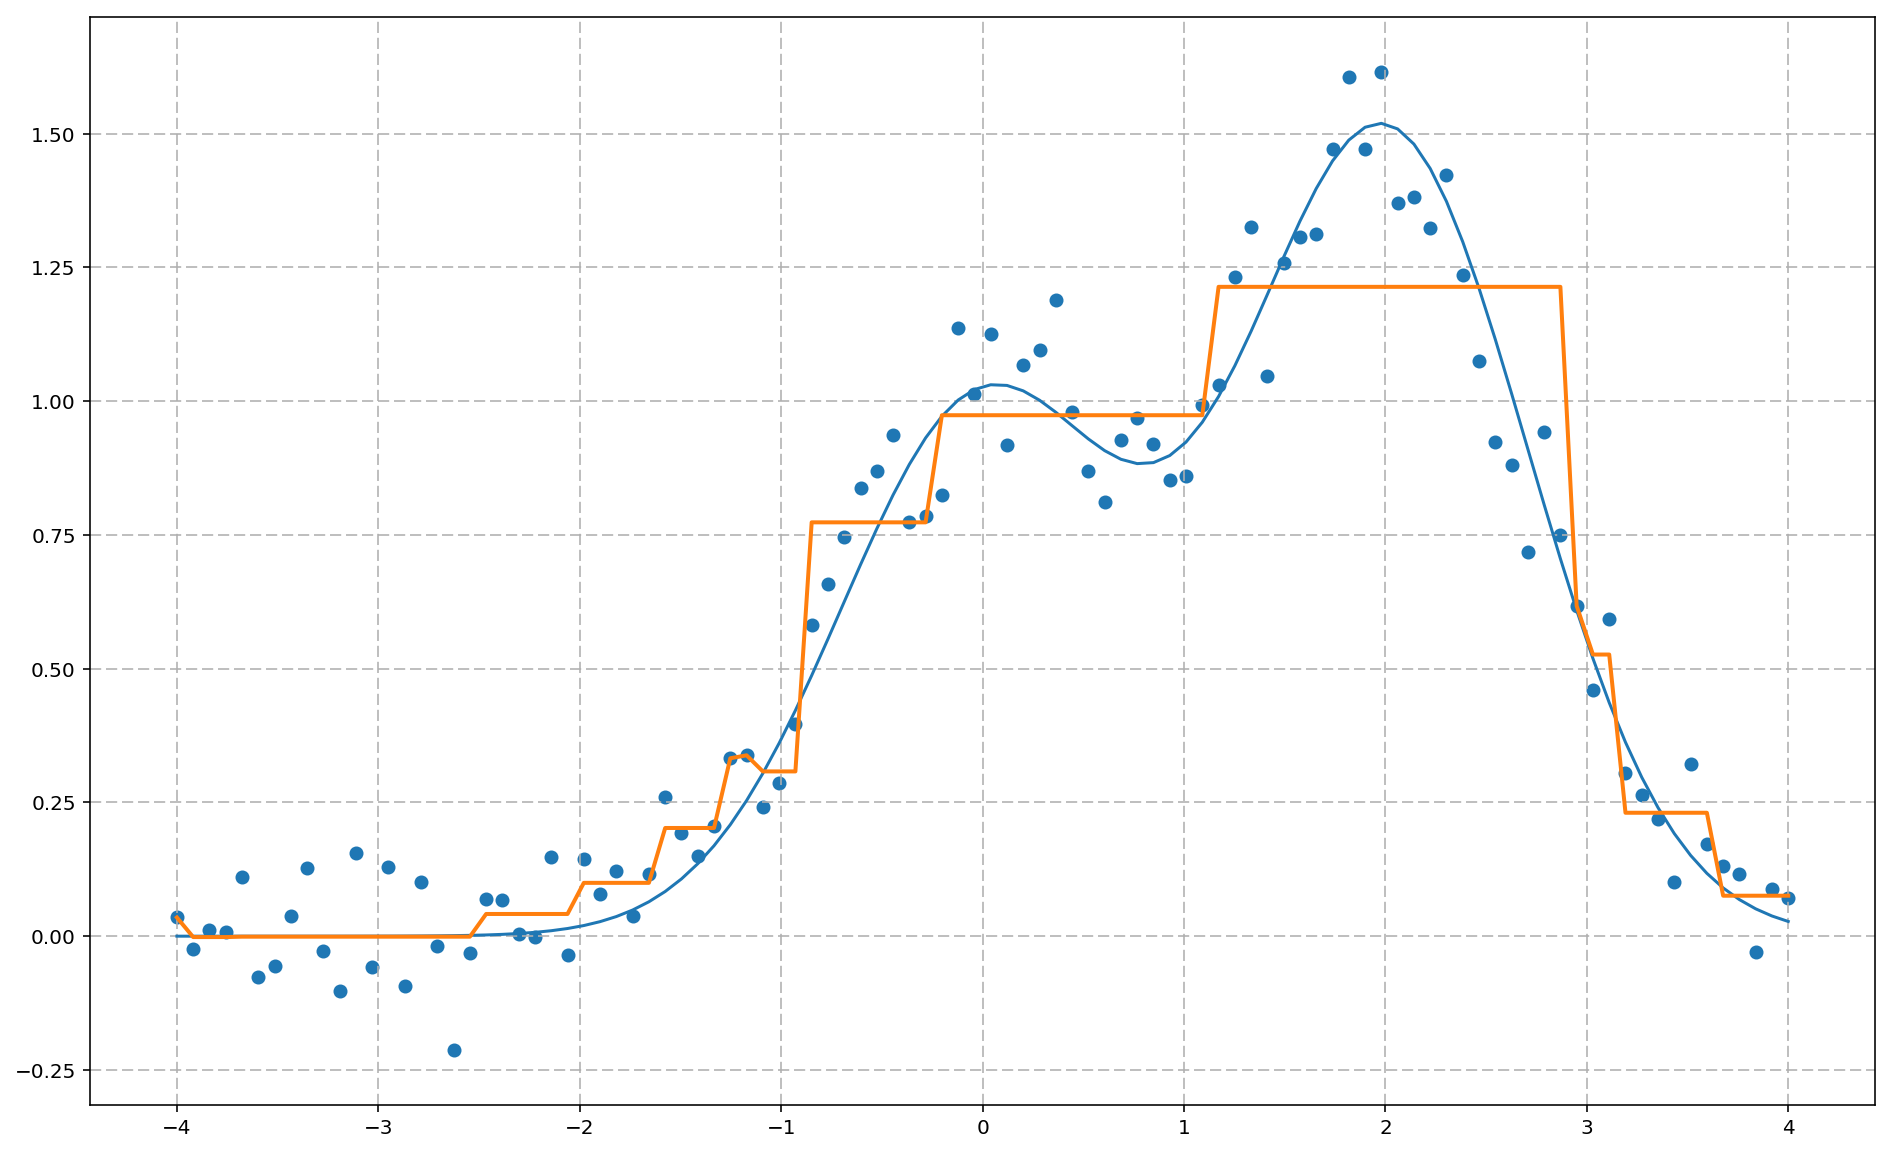

In [15]:
from sklearn.model_selection import train_test_split

x = np.linspace(-4, 4, num=100)
y = np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)
y_noised = y + np.random.normal(scale=.1, size=100)

x = x.reshape(len(x), 1)

dtr = DecisionTreeRegressor(max_depth=4)
dtr.fit(x, y_noised)

plt.figure(figsize=(16, 10))
plt.grid(linestyle='--')
plt.plot(x, y)
plt.scatter(x, y_noised)
plt.plot(x, dtr.predict(x), lw=2)
plt.show()